# Visualizando o Backward Pass e o Fluxo de Gradiente com Autograd


<table >
  <td>
    <a href="https://colab
    - research.google.com/github/fabiobento/dnn-course-2026-1/blob/main/aulas/dl-pytorch/intro-dl/docs/autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/fabiobento/dnn-course-2026-1/blob/main/aulas/dl-pytorch/intro-dl/docs/autograd.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

## Step 1: Set Up the Environment

No código abaixo configuramos o ambiente.

- Esta célula código configura o ambiente PyTorch e garante que tudo seja reproduzível.
    - Ao definir uma semente aleatória com `torch.manual_seed(42)`, garantimos que o modelo comece da mesma maneira toda vez que o executarmos.

In [1]:
# Step 1: Set Up the Environment
import torch
import torch.nn as nn
import torch.optim as optim

# For reproducibility: ensures that initial weights and any other random operations
torch.manual_seed(42)

## Step 2: Constructing a Simple Neural Network

Agora, vamos construir uma rede neural simples, igual à do laboratório anterior.

- Este código define uma rede neural minúscula chamada `SimpleNN` com apenas uma camada.
    - Ela recebe dois recursos de entrada e fornece uma saída.
    - A função `forward` diz ao modelo como processar a entrada

In [2]:
# Step 2: Constructing a Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Define a single fully connected linear layer.
        # It takes 2 input features and produces 1 output feature.
        # PyTorch automatically initializes weights and biases for this layer.
        # By default, parameters of nn.Module (like weights of nn.Linear)
        # have requires_grad=True, so autograd will track operations on them.
        self.fc1 = nn.Linear(in_features=2, out_features=1)

    def forward(self, x):
        # Defines the forward pass: how input x is transformed to an output.
        x = self.fc1(x)
        return x

## Step 3: Generating Sample Data and Instantiating Model & Optimizer


Aqui está a configuração do nosso experimento.
- Criamos três pontos de dados para nossa rede neural.
    - Cada um tem duas "perguntas"
        - esses são nossos recursos (*features*).
    - E sabemos a resposta correta para cada uma
        - esses são nossos alvos (*targets*), sendo 1 ou 0.

In [3]:
# Step 3: Generating Sample Data and Instantiating Model & Optimizer

# Input data X (3 samples, 2 features each).
# Note: We do NOT set requires_grad=True for X here, because X is our fixed input data.
# We are interested in gradients of the loss with respect to MODEL PARAMETERS, not inputs.
X = torch.tensor([[1.0, 2.0],
                  [3.0, 5.0],
                  [5.0, 8.0]], dtype=torch.float32)

# Target data y (corresponding labels for X).
y_true = torch.tensor([[0.0],
                       [1.0],
                       [1.0]], dtype=torch.float32)

Quando criamos nossa rede neural, ela ainda não tem ideia de quais são as respostas certas.
    - Ela começa com pesos (*weights*) e vieses (*biases*) aleatórios.
    - Esses números que você vê são como seus palpites iniciais sobre quais informações importam. Eles são aleatórios.

In [4]:
# Instantiate the model
model = SimpleNN()

# Let's inspect the initial (randomly initialized) weights and bias
print("--- Initial Model Parameters ---")
print(f"Initial weights (fc1.weight): {model.fc1.weight.data}")
print(f"Initial bias (fc1.bias): {model.fc1.bias.data}")

--- Initial Model Parameters ---
Initial weights (fc1.weight): tensor([[0.5406, 0.5869]])
Initial bias (fc1.bias): tensor([-0.1657])


Também usaremos mais 2 ferramentas importantes:
- uma função de perda (*loss function*), que funciona como um marcador de pontuação para o quão errados nossos palpites estão, e
- um otimizador (*optimizer*), que diz à rede como se ajustar para obter pontuações melhores. 

A taxa de aprendizado (*learning rate*) do nosso otimizador é 0.01. Isso é como dizer à nossa rede: "dê passos pequenos e cuidadosos enquanto estiver aprendendo e não exagere na reação".

In [5]:
# Define the loss function
# Mean Squared Error (MSE) is common for regression tasks, or simple demonstrations.
criterion = nn.MSELoss()

# Define the optimizer
# Stochastic Gradient Descent (SGD) will be used to update model parameters.
# We pass model.parameters() to tell the optimizer which tensors it should update.
# lr is the learning rate.
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Step 4: Forward Pass and Loss Computation

Agora vamos ver quais previsões nossa rede não treinada faz e como elas se comparam às respostas reais.
    - O modelo previu valores como 1.54, 4.39 e 7.23 para os três pontos de entrada.
    - A perda calculada é 17.5804, o que nos diz que as previsões estão bem distantes
        - Isso não é surpreendente, já que ela não foi treinada.

In [6]:
# Step 4: Forward Pass and Loss Computation

# Perform the forward pass: get model's predictions for input X
# This internally calls the model's forward() method.
predictions = model(X)
print(f"\n--- Forward Pass ---")
print(f"Model predictions for X:\n{predictions.data}")

# Compute the loss by comparing model's predictions with true labels y_true
loss = criterion(predictions, y_true)
print(f"Computed Loss: {loss.item():.4f}")
# The 'loss' tensor now has a computational graph attached to it,
# tracing back through 'predictions' to the model's parameters.


--- Forward Pass ---
Model predictions for X:
tensor([[1.5488],
        [4.3907],
        [7.2326]])
Computed Loss: 17.5804


## Step 5: Visualizing the Backward Pass (Computing Gradients)


- Antes de calcular novos gradientes, limpamos os antigos.
-   Se não fizermos isso, os gradientes de etapas anteriores podem atrapalhar as coisas.

- O *Backward Pass* é a etapa fundamental onde o PyTorch realiza a retropropagação (*backpropagation*).
    - Isso calcula o quanto cada parâmetro (pesos e viés) contribuiu para o erro (*loss*).
    - Esses valores são armazenados no atributo `.grad` de cada parâmetro.

In [7]:
# Step 5: Visualizing the Backward Pass (Computing Gradients)

# Before computing gradients for the current pass, it's essential to zero out
# any gradients accumulated from previous passes (if any).
# For this single demonstration, model parameters' .grad attributes are initially None.
# However, in a training loop, this is crucial.
optimizer.zero_grad()
# You could also do: model.zero_grad()

# Perform the backward pass: compute gradients of the loss with respect to
# all tensors in the computation graph that have requires_grad=True (i.e., model parameters).
# These gradients are stored in the .grad attribute of each parameter.
loss.backward()

print("\n--- Backward Pass (Gradients Computed) ---")



--- Backward Pass (Gradients Computed) ---


O loop abaixo imprime os gradientes para cada parâmetro.
- Ele mostra:
    - de qual parâmetro estamos falando, como `fc1.weight`, e
    - qual é o gradiente — ou seja, o quanto ele deve mudar para reduzir o erro.
- Assim, o modelo aprendeu como a perda muda se ajustarmos levemente cada peso ou viés.

Por exemplo:
- `fc1.weight` tem gradientes como 28.5893 e 46.6080, o que significa que esses pesos precisam de um ajuste considerável.
- Já o viés `fc1.bias` tem um gradiente de 7.4481.

In [8]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}")
        # print(f"  Value: {param.data}") # Current value of the parameter
        print(f"  Gradient (dLoss/dParam): {param.grad.data}")

Parameter: fc1.weight
  Gradient (dLoss/dParam): tensor([[28.5893, 46.6080]])
Parameter: fc1.bias
  Gradient (dLoss/dParam): tensor([7.4481])


## Step 6: Updating Model Parameters (Applying Gradients)


Aqui é o momento em que o modelo realmente aprende e atualiza os pesos e vieses.

O comando `optimizer.step()` diz ao otimizador: "use o gradiente que acabamos de calcular e atualize os pesos e o viés".

Em seguida, imprimimos os valores atualizados para que possamos ver o que mudou.

In [9]:

# The optimizer uses the computed gradients (stored in param.grad)
# to update the model's parameters.
# The update rule for basic SGD is: new_weight = old_weight - learning_rate * gradient
optimizer.step()

print("\n--- Model Parameters After Optimizer Step ---")
print(f"Updated weights (fc1.weight): {model.fc1.weight.data}")
print(f"Updated bias (fc1.bias): {model.fc1.bias.data}")


--- Model Parameters After Optimizer Step ---
Updated weights (fc1.weight): tensor([[0.2547, 0.1208]])
Updated bias (fc1.bias): tensor([-0.2401])


Quando aplicamos os gradientes:
- os pesos do modelo foram atualizados para 0.2547 e 0.1208 e
- o viés mudou para -0.2401.

Esses números são as novas configurações internas do modelo — sua nova estratégia para fazer previsões após aprender com o erro anterior.

Agora, passaremos a mesma entrada `X` pelo modelo novamente, mas desta vez com os pesos atualizados.

Desativamos o rastreamento de gradiente (`torch.no_grad()`) porque estamos apenas verificando o desempenho, não treinando.

Agora a nova perda deve ser menor que antes, e é assim que sabemos que o aprendizado está acontecendo.

In [10]:
# For verification, let's do another forward pass with the updated weights
# and see if the loss has decreased (it should, for a well-behaved problem).
with torch.no_grad(): # Disable gradient tracking for this verification forward pass
    new_predictions = model(X)
    new_loss = criterion(new_predictions, y_true)
print(f"\nLoss after one optimization step: {new_loss.item():.4f}")
# Initial Loss: [loss.item() from Step 4]
# Loss After 1 Step: [new_loss.item() from Step 6]


Loss after one optimization step: 0.3607


- Observe que a perda realmente caiu para 0.3607, o que significa que o modelo já está fazendo um trabalho melhor após apenas um passo de treinamento.

Agora vamos criar uma comparação visual:
- A linha vermelha mostra o que o modelo previu antes de aprender.
- A linha verde mostra as previsões atualizadas após apenas uma etapa de otimização.
- Os pontos são os dados reais.

Isso serve para que você possa ver que o modelo está começando a se aproximar das respostas reais.

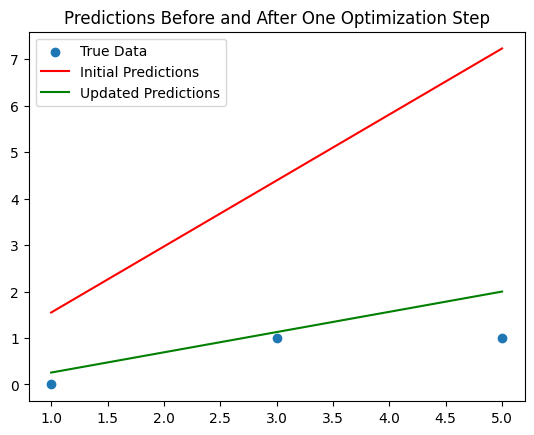

In [11]:

# If plotting library was available and X was 1D:
import matplotlib.pyplot as plt
plt.scatter(X.numpy()[:, 0], y_true.numpy(), label='True Data')
plt.plot(X.numpy()[:, 0], predictions.detach().numpy(), color='red', label='Initial Predictions')
plt.plot(X.numpy()[:, 0], new_predictions.detach().numpy(), color='green', label='Updated Predictions')
plt.legend()
plt.title('Predictions Before and After One Optimization Step')
plt.show()

- Observe o gráfico acima:
    - Os pontos azuis são os valores reais que queremos que o modelo preveja, e
    - a linha vermelha mostra a primeira tentativa do modelo baseada em pesos aleatórios (**estava bem longe**).
    - A linha verde é a nova previsão do modelo após o aprendizado.
    
E o que você vê?
> A linha verde está se aproximando dos pontos azuis, o que significa que o modelo já está aprendendo com seus erros e melhorando.

O que acabamos de testemunhar com nossa rede é que ela:
- fez alguns palpites errados,
- descobriu em qual direção deveria ajustar seu "pensamento" (gradiente),
- fez esses ajustes (atualizações de parâmetros) e
- melhorou drasticamente suas previsões.